In [1]:
import pandas as pd


file_path = 'modified_california_counties.csv'
data = pd.read_csv(file_path)
data.drop(['State'], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   County                       58 non-null     object 
 1   Urban_Percentage             58 non-null     float64
 2   Total_Population             58 non-null     float64
 3   Housing_Units                58 non-null     float64
 4   Median_Family_Income         58 non-null     float64
 5   Population_Half_Percent      58 non-null     float64
 6   Low_Income_Half_Percent      58 non-null     float64
 7   Vehicle_Half_Percent         58 non-null     float64
 8   Population_1_Percent         58 non-null     float64
 9   Low_Income_1_Percent         58 non-null     float64
 10  Vehicle_1_Percent            58 non-null     float64
 11  Grocery stores, 2016         58 non-null     float64
 12  Convenience stores, 2016     58 non-null     float64
 13  Fast-food restaurants,

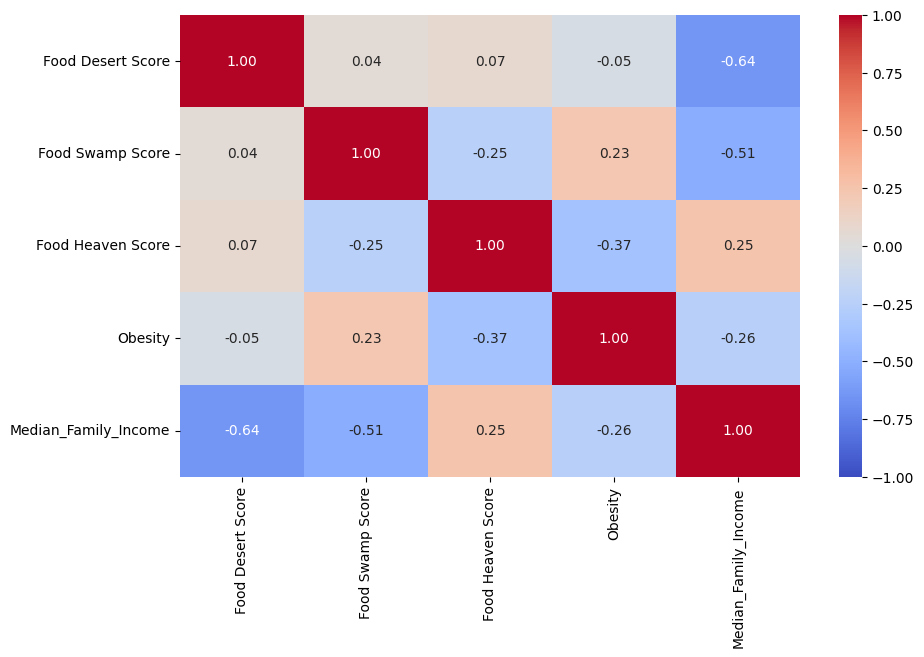

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


food_desert_vars = ['Vehicle_Half_Percent', 'Population_Half_Percent', 'Low_Income_Half_Percent',
                    'Population_1_Percent', 'Low_Income_1_Percent', 'Vehicle_1_Percent']
food_swamp_vars = ['Convenience stores, 2016', 'Fast-food restaurants, 2016', 'Fast Food', 'Soda ']
food_heaven_vars = ['Grocery stores, 2016', 'Farmers\' markets, 2018', 'Fruit ', 'Veggie']

subset_data = data[['County'] + food_desert_vars + food_swamp_vars + food_heaven_vars + ['Obese', 'Median_Family_Income']].dropna()

# Standardizing the variables
scaler = StandardScaler()
standardized_data = scaler.fit_transform(subset_data[food_desert_vars + food_swamp_vars + food_heaven_vars])


weighted_food_desert_score = standardized_data[:, :len(food_desert_vars)]
subset_data['Food Desert Score'] = weighted_food_desert_score.mean(axis=1)


subset_data['Food Swamp Score'] = standardized_data[:, len(food_desert_vars):len(food_desert_vars) + len(food_swamp_vars)].mean(axis=1)
subset_data['Food Heaven Score'] = standardized_data[:, len(food_desert_vars) + len(food_swamp_vars):].mean(axis=1)

# Validation
correlations = subset_data[['Food Desert Score', 'Food Swamp Score', 'Food Heaven Score', 'Obese', 'Median_Family_Income']].rename(columns={'Obese': 'Obesity'}).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.savefig('county_scores_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

new_file_path = 'california_counties_with_scores.csv'
subset_data.to_csv(new_file_path, index=False)


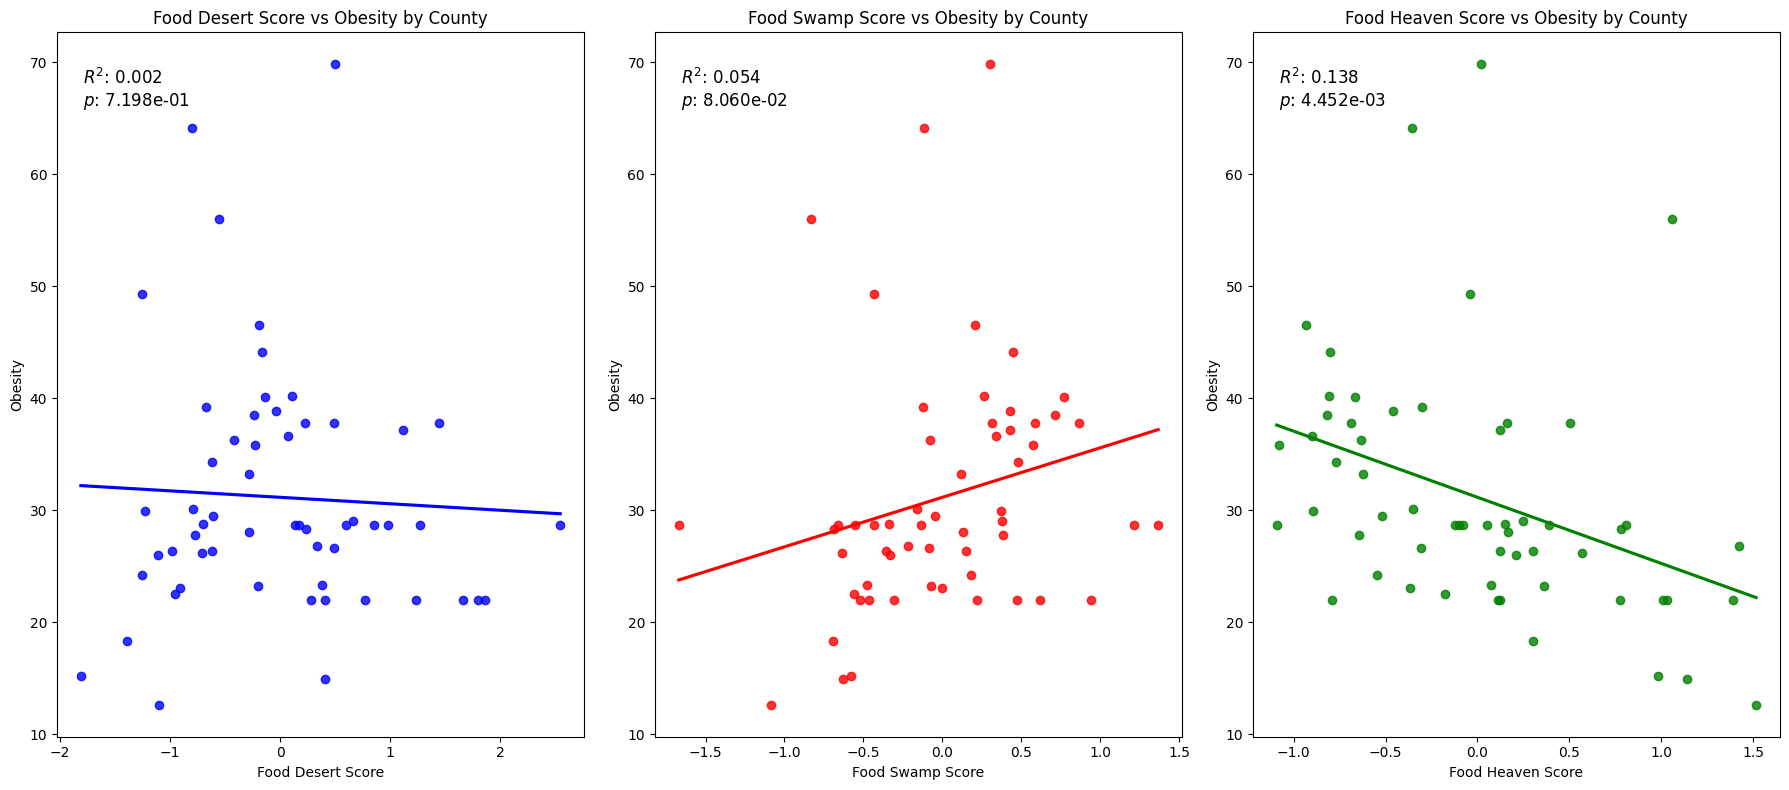

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


def annotate_stats(x, y, ax):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.text(0.05, 0.95, f'$R^2$: {r_value**2:.3f}\n$p$: {p_value:.3e}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot 1: Food Desert Score vs Obesity
sns.regplot(data=subset_data, x='Food Desert Score', y='Obese', color='blue', ci=None, ax=axes[0])
axes[0].set_title('Food Desert Score vs Obesity by County')
axes[0].set_xlabel('Food Desert Score')
axes[0].set_ylabel('Obesity')
annotate_stats(subset_data['Food Desert Score'], subset_data['Obese'], axes[0])

# Plot 2: Food Swamp Score vs Obesity
sns.regplot(data=subset_data, x='Food Swamp Score', y='Obese', color='red', ci=None, ax=axes[1])
axes[1].set_title('Food Swamp Score vs Obesity by County')
axes[1].set_xlabel('Food Swamp Score')
axes[1].set_ylabel('Obesity')
annotate_stats(subset_data['Food Swamp Score'], subset_data['Obese'], axes[1])

# Plot 3: Food Heaven Score vs Obesity
sns.regplot(data=subset_data, x='Food Heaven Score', y='Obese', color='green', ci=None, ax=axes[2])
axes[2].set_title('Food Heaven Score vs Obesity by County')
axes[2].set_xlabel('Food Heaven Score')
axes[2].set_ylabel('Obesity')
annotate_stats(subset_data['Food Heaven Score'], subset_data['Obese'], axes[2])

plt.tight_layout()
plt.savefig('combined_scatter_plots_county.png', dpi=300, bbox_inches='tight')

plt.show()


In [4]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.0 MB/s eta 0:00:00


In [5]:
import json


geojson_path = 'California_County_Boundaries.geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)


geojson_data.keys()


dict_keys(['type', 'name', 'crs', 'features'])

In [13]:
import pandas as pd
import plotly.express as px
import json
from PIL import Image

california_data = pd.read_csv('california_counties_with_scores.csv')


geojson_path = 'California_County_Boundaries.geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)

for feature in geojson_data['features']:
    if 'properties' in feature and 'CountyName' in feature['properties']:
        feature['id'] = feature['properties']['CountyName']


fig1 = px.choropleth(
    california_data,
    geojson=geojson_data,
    locations='County',
    featureidkey='properties.CountyName',
    color='Food Desert Score',
    color_continuous_scale="Blues",
    scope="usa",
    title="Food Desert Score by County in California"
)
fig1.update_geos(fitbounds="locations", visible=False)
fig1.write_image('food_desert_score_by_county_ca.png')

# Food Swamp Score
fig2 = px.choropleth(
    california_data,
    geojson=geojson_data,
    locations='County',
    featureidkey='properties.CountyName',
    color='Food Swamp Score',
    color_continuous_scale="Reds",
    scope="usa",
    title="Food Swamp Score by County in California"
)
fig2.update_geos(fitbounds="locations", visible=False)
fig2.write_image('food_swamp_score_by_county_ca.png')

# Food Heaven Score
fig3 = px.choropleth(
    california_data,
    geojson=geojson_data,
    locations='County',
    featureidkey='properties.CountyName',
    color='Food Heaven Score',
    color_continuous_scale="Greens",
    scope="usa",
    title="Food Heaven Score by County in California"
)
fig3.update_geos(fitbounds="locations", visible=False)
fig3.write_image('food_heaven_score_by_county_ca.png')

# Obesity Rate
fig4 = px.choropleth(
    california_data,
    geojson=geojson_data,
    locations='County',
    featureidkey='properties.CountyName',
    color='Obese',
    color_continuous_scale="peach",
    scope="usa",
    title="Obesity Rate by County in California"
)
fig4.update_geos(fitbounds="locations", visible=False)
fig4.write_image('obesity_rate_by_county_ca.png')

# Median Income
fig5 = px.choropleth(
    california_data,
    geojson=geojson_data,
    locations='County',
    featureidkey='properties.CountyName',
    color='Median_Family_Income',
    color_continuous_scale="teal",
    scope="usa",
    title="Median Income by County in California"
)
fig5.update_geos(fitbounds="locations", visible=False)
fig5.write_image('median_income_by_county_ca.png')

images = [
    Image.open('food_desert_score_by_county_ca.png'),
    Image.open('food_swamp_score_by_county_ca.png'),
    Image.open('food_heaven_score_by_county_ca.png'),
    Image.open('obesity_rate_by_county_ca.png'),
    Image.open('median_income_by_county_ca.png')
]


width, height = images[0].size

combined_image = Image.new('RGB', (2 * width, 3 * height), (255, 255, 255))

combined_image.paste(images[0], (0, 0))
combined_image.paste(images[1], (width, 0))
combined_image.paste(images[2], (0, height))
combined_image.paste(images[3], (width, height))
combined_image.paste(images[4], (0, 2 * height))


combined_image.save('combined_county_maps_ca.png')


combined_image.show()
